In [1]:
from functools import partial, reduce, lru_cache
import numpy as np
import pandas as pd
import fitpack
import interface
import obslib.sidis.reader
from qcdlib.auxiliary import AUX
from qcdlib.collinearity import Collinearity
from tools.config import conf
%matplotlib notebook 

In [2]:
def get_data():
    # Merge all of the data tables
    return reduce(partial(pd.DataFrame.merge, how="outer"), map(pd.DataFrame, conf["sidis tabs"].values()))

In [3]:
input_file = "../inputs/upol_hermes_no_filters.py"

In [4]:
interface.gen_config(input_file)  # read file

conf["aux"] = AUX()
conf["sidis tabs"] = obslib.sidis.reader.READER().load_data_sets("sidis")

data = get_data()

loading sidis data sets 1007

In [5]:
print(", ".join(sorted(data.columns)))

Ebeam, F2, Q2, R, R0, R1, R2, W2, col, dy, hadron, i, lnR, obs, pT, qT, stat_u, systabs_u, systole, systrel, target, value, x, xn, y, yf, yh, yi, yp, z, zn


In [6]:
print("len(data):", len(data))

len(data): 2660


In [7]:
ki_n = 8
kf_n = 8
kT_n = 8

k_sets_n = ki_n * kf_n * kT_n

kis = np.linspace(0, 2, ki_n)
kfs = np.linspace(0, 2, kf_n)
kTs = np.linspace(0, 2, kT_n)

@lru_cache(maxsize=None)
def Rs(x, z, Q2, pT, hadron, ki, kf, kT):
    co = Collinearity(hadron=hadron, ki=ki, kf=kf, kT=kT)
    R0 = co.get_R0(Q2)
    R1 = co.get_R1(x, z, Q2, pT)
    R2 = co.get_R1(x, z, Q2, pT)
    return R0, R1, R2

def R_mags(point):
    for ki in kis:
        for kf in kfs:
            for kT in kTs:
                R0, R1, R2 = Rs(point["x"], point["z"], point["Q2"], point["pT"],
                                point["hadron"], ki, kf, kT)
                yield np.sqrt(R0 ** 2 + R1 ** 2 + R2 ** 2)

def proximity(point):
    return sum(mag <= 1 for mag in R_mags(point)) / k_sets_n

In [8]:
_, p = next(data.iterrows())

p

i                    0
Ebeam             27.6
x            0.0375884
y             0.641938
z             0.152202
Q2             1.24973
pT            0.110571
obs                  M
value          4.39848
stat_u       0.0575923
systrel              0
systabs_u     0.350294
target          proton
hadron             pi+
col             hermes
F2                   0
W2             32.8795
yh           0.0273122
yp             3.45654
yi             0.80461
yf            -0.80461
dy             3.42923
R              1.59268
lnR           0.465419
R0           0.0720157
R1           0.0117231
R2            0.847018
zn            0.151891
xn            0.151891
qT            0.727962
systole            NaN
Name: 0, dtype: object

In [9]:
print("proximity(p):", proximity(p))

print("min |R|, p:", min(R_mags(p)))

print("avg |R|, p", sum(R_mags(p)) / k_sets_n)

print("max |r|, p", max(R_mags(p)))

proximity(p): 0.03125
min |R|, p: 0.6759339884486435
avg |R|, p 2.6005849301612125
max |r|, p 3.7512320187581247


In [10]:
data["min |R|"] = [min(R_mags(p)) for _, p in data.iterrows()]

data["min |R|"]

0       0.675934
1       2.039722
2       2.248814
3       2.379128
4       2.488861
          ...   
2655    0.042262
2656    0.027409
2657    0.012888
2658    0.006310
2659    0.048425
Name: min |R|, Length: 2660, dtype: float64

In [11]:
sum(data["min |R|"] < 1.0)

1873

In [12]:
data["avg |R|"] = [sum(R_mags(p)) / k_sets_n for _, p in data.iterrows()]

data["avg |R|"]

0       2.600585
1       4.057499
2       3.554357
3       3.485112
4       3.498716
          ...   
2655    0.289342
2656    0.291671
2657    0.303748
2658    0.331910
2659    0.375875
Name: avg |R|, Length: 2660, dtype: float64

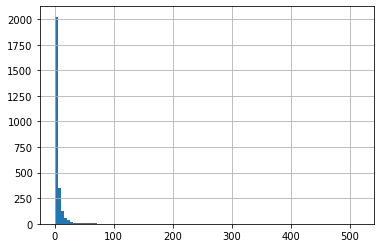

In [13]:
data["avg |R|"].hist(bins=100)

In [14]:
max(data["avg |R|"])

515.3581507778546

In [15]:
data["proximity"] = [proximity(p) for _, p in data.iterrows()]

data["proximity"]

0       0.03125
1       0.00000
2       0.00000
3       0.00000
4       0.00000
         ...   
2655    1.00000
2656    1.00000
2657    1.00000
2658    1.00000
2659    1.00000
Name: proximity, Length: 2660, dtype: float64

In [16]:
max(data["proximity"])

1.0

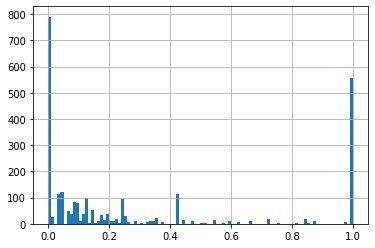

In [17]:
data["proximity"].hist(bins=100)

In [18]:
print("Average proximity:", data["proximity"].mean())

Average proximity: 0.31680421757518795
